In [2]:
import sys
sys.path.append('..')
import tangles
import cost_functions
import cut_finding
import importlib
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.cluster import KMeans
import sklearn.metrics
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.datasets import make_blobs

import sklearn.metrics
import tqdm

import importlib
import time
import cut_finding
import plotting
import dataset_generation
from numpy_kmeans import NumpyKMeans


def reload():
    importlib.reload(tangles)
    importlib.reload(cost_functions)
    importlib.reload(cut_finding)
    importlib.reload(tangles)
    importlib.reload(plotting)
    importlib.reload(dataset_generation)


In [12]:
from functools import partial

import sklearn.preprocessing

reload()

runs = 100

seed_start = random.randint(0, 1000000)
seeds = range(seed_start, seed_start + runs)

results = []
k = 50

axis_parallel_cut_function = partial(cut_finding.axis_parallel_cuts, k=k)
local_two_means = partial(cut_finding.local_two_means, k=k)

cut_function = axis_parallel_cut_function
cost_class = partial(cost_functions.SimilarityMatrix, margin=0.1)

def means_func(size):
    return 10 * np.random.random(size=size)

clusters_sizes = [5]
dimensions = 2

min_distance = 3

data_sizes = [1000]
for n_clusters in clusters_sizes:
    for data_size in reversed(data_sizes):
        for i in tqdm.tqdm(range(runs)):
            np.random.seed(seeds[i])
            data, labels = dataset_generation.create_2d_test_data(
                means_func=means_func,
                n_clusters=n_clusters,
                dimensions=dimensions,
                scales=np.random.choice([0.5, 2], size=(n_clusters, dimensions)),
                # weights=0.25 + 0.75*np.random.random(size=n_clusters),
                weights = np.ones(n_clusters),
                min_distance= min_distance,
                num_samples=data_size
            )

            data = sklearn.preprocessing.MinMaxScaler().fit_transform(data)

            agreement_param = (min(Counter(labels).values()) * (0.35)) / len(labels)
            models = {
                "Tangles": partial(tangles.TangleClustering,
                                            cost_class=cost_class,
                                            cut_function=cut_function,
                                            agreement_param=agreement_param
                                            ),
                "TanglesRecompute": partial(tangles.TangleClustering,
                                            cost_class=cost_class,
                                            cut_function=cut_function,
                                            agreement_param=agreement_param,
                                            recompute_costs_on_split=True
                                            ),
            }

            current_results = []

            for model_name, Model in models.items():

                starttime = time.time()
                model = Model(n_clusters=n_clusters)
                preds = model.fit_predict(data)
                time_ = time.time() - starttime
                nmi = sklearn.metrics.normalized_mutual_info_score(labels, preds)

                current_results.append([ model_name,  n_clusters, data_size,
                                        nmi, seeds[i], time_, dimensions])

            results.extend(current_results)

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


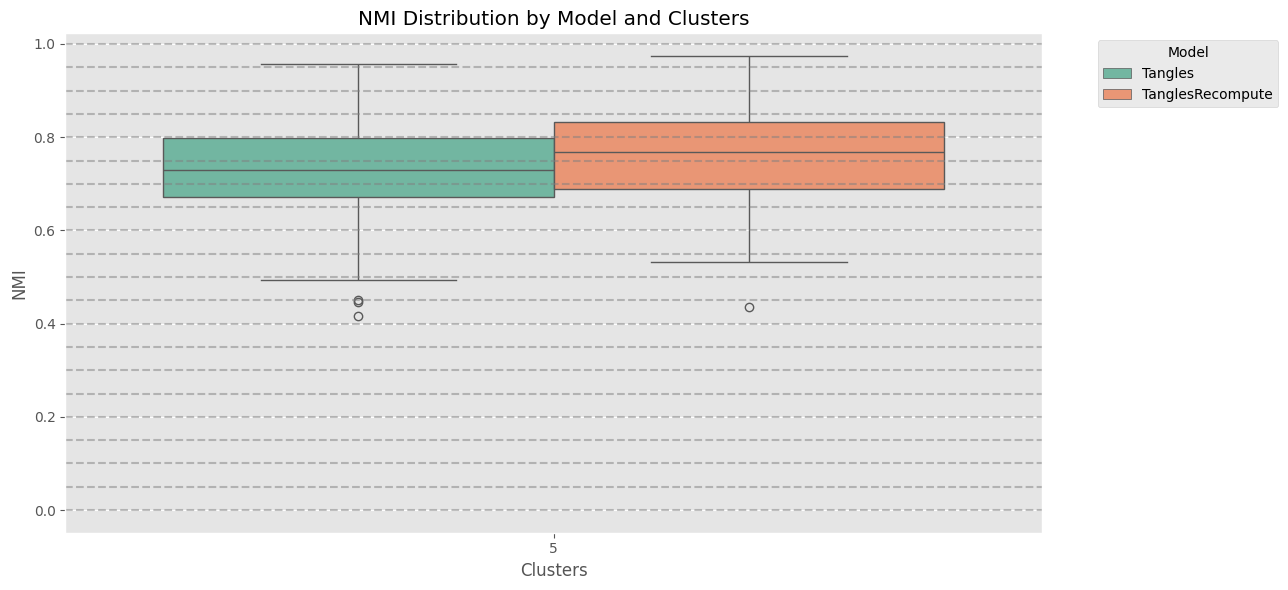

In [13]:
df = pd.DataFrame(results, columns=["Model", "Clusters", "Data-Size",
                                    "NMI", "Seed", "Time", "Dimensions"])

plotting.BoxPlot(df).nmi()

In [14]:
from collections import defaultdict

diff_to_recompute = defaultdict(dict)

max_diff = 0
for i in range(0, len(df), 2):
    seed = df.iloc[i]["Seed"]
    n_clusters = df.iloc[i]["Clusters"]
    tangles_nmi = df.iloc[i]['NMI']
    recompute_nmi = df.iloc[i+1]['NMI']
    diff_to_recompute[n_clusters][seed] = recompute_nmi - tangles_nmi
    max_diff = max(max_diff, abs(recompute_nmi - tangles_nmi))

print(max_diff)

biggest_difference = {
    2: {'worst': [], 'best': []},
    3: {'worst': [], 'best': []},
    5: {'worst': [], 'best': []},
    7: {'worst': [], 'best': []}
}

d = diff_to_recompute

for n_clusters in d.keys():
    best = sorted(d[n_clusters], key=d[n_clusters].get, reverse=True)
    worst = sorted(d[n_clusters], key=d[n_clusters].get)
    biggest_difference[n_clusters]['worst'] = worst
    biggest_difference[n_clusters]['best'] = best

0.28473689705560296


Clusters: 2
best
Clusters: 2
worst
Clusters: 3
best
Clusters: 3
worst
Clusters: 5
best


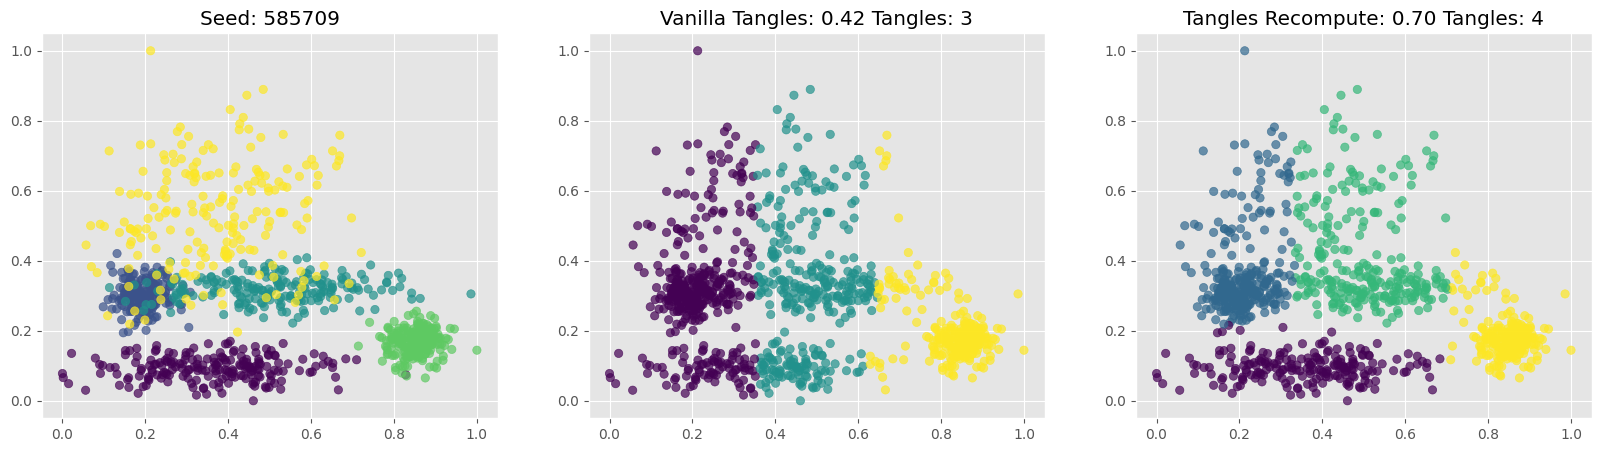

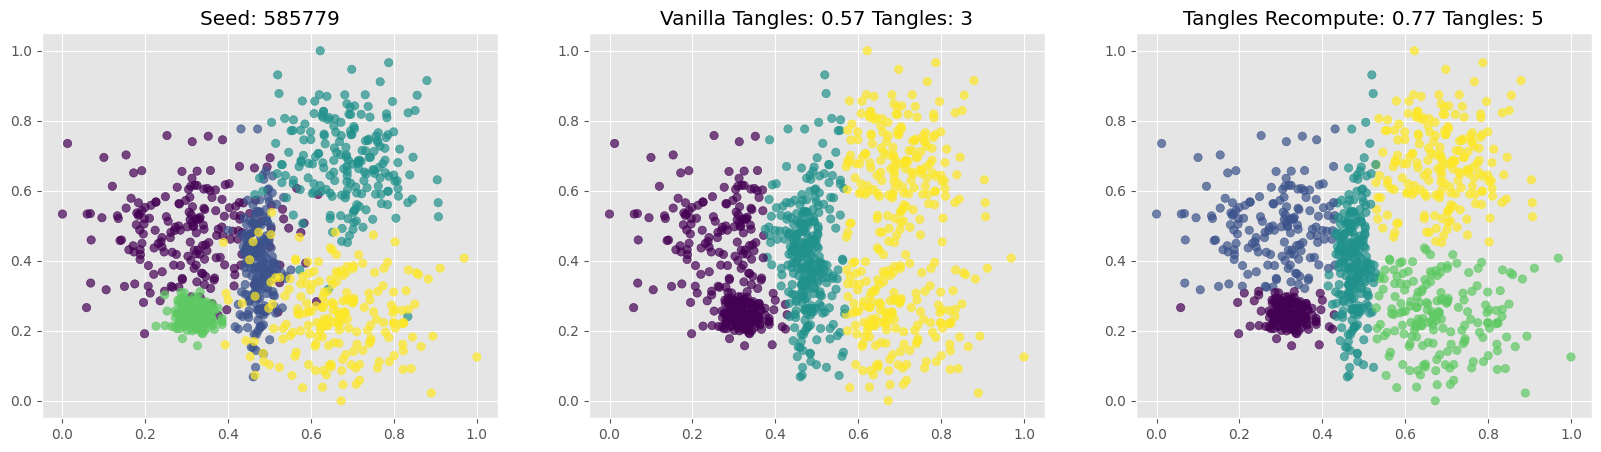

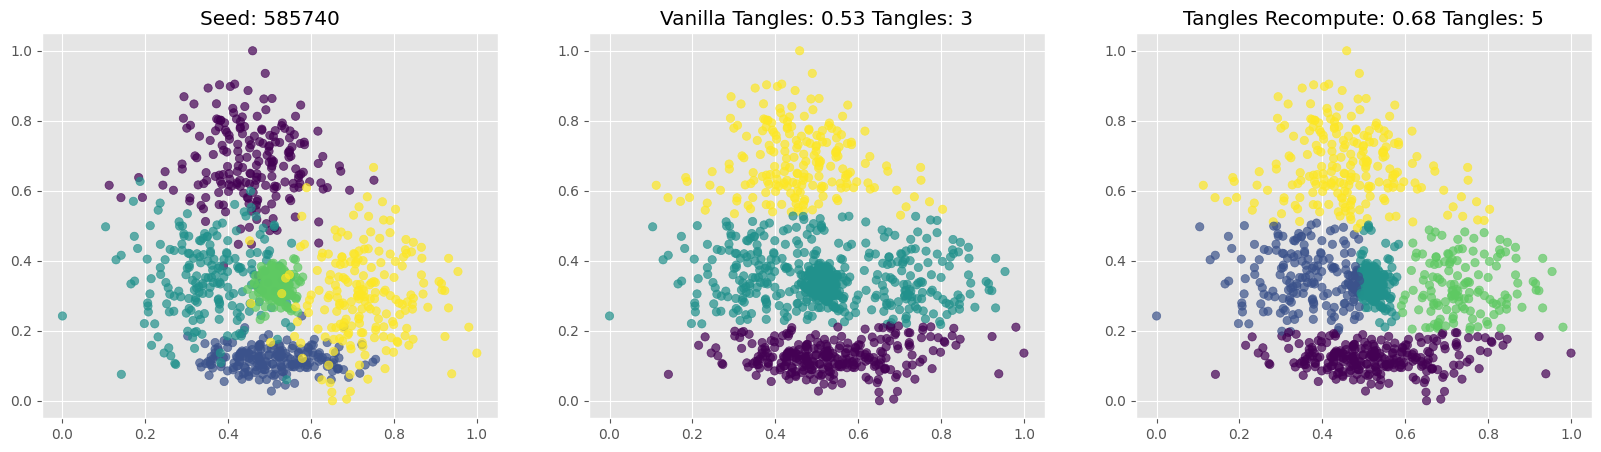

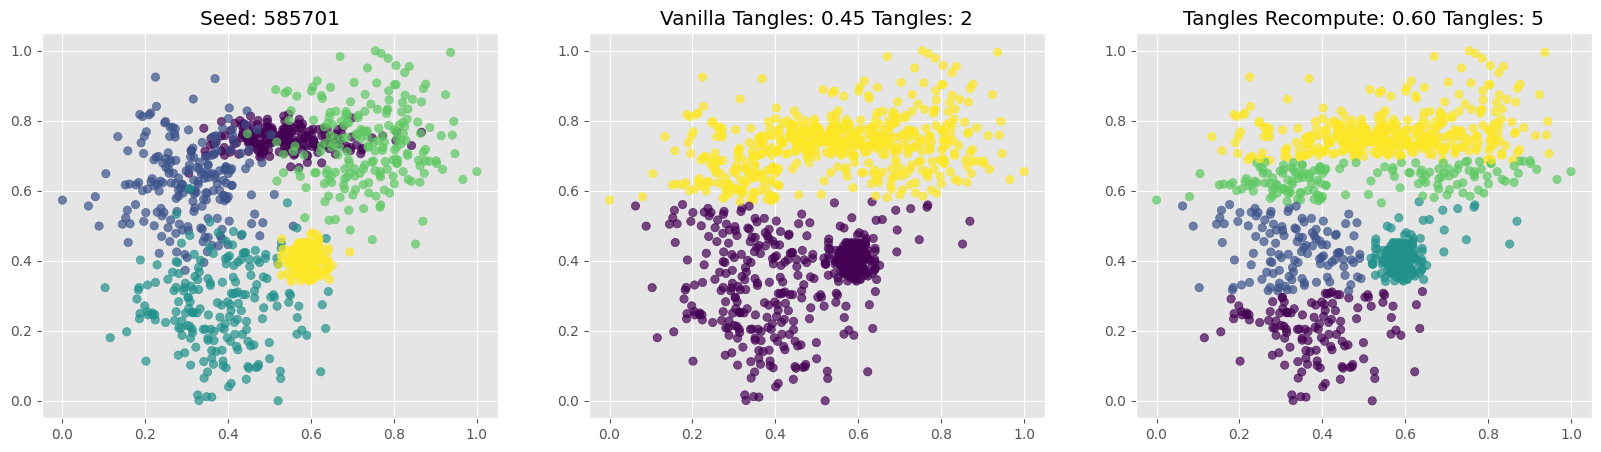

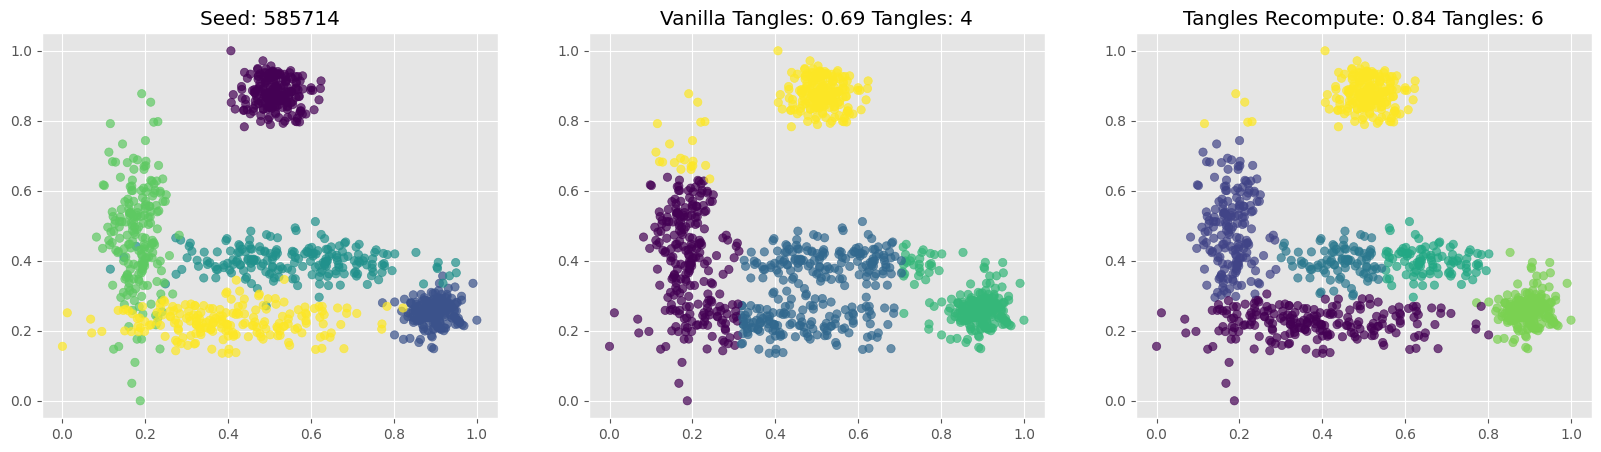

Clusters: 5
worst


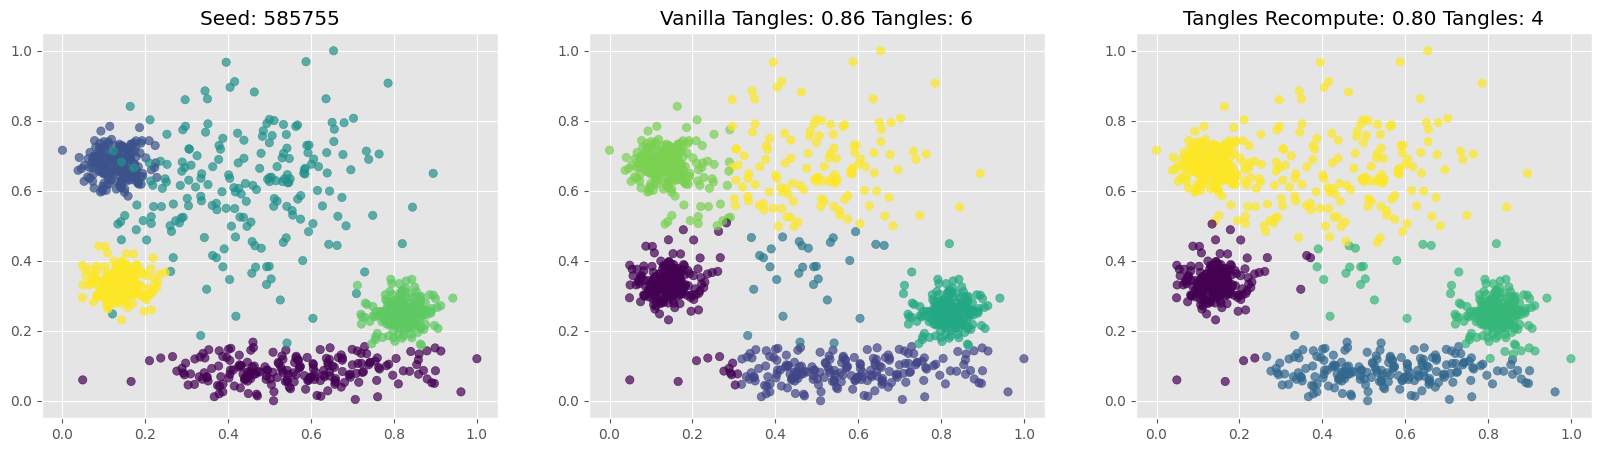

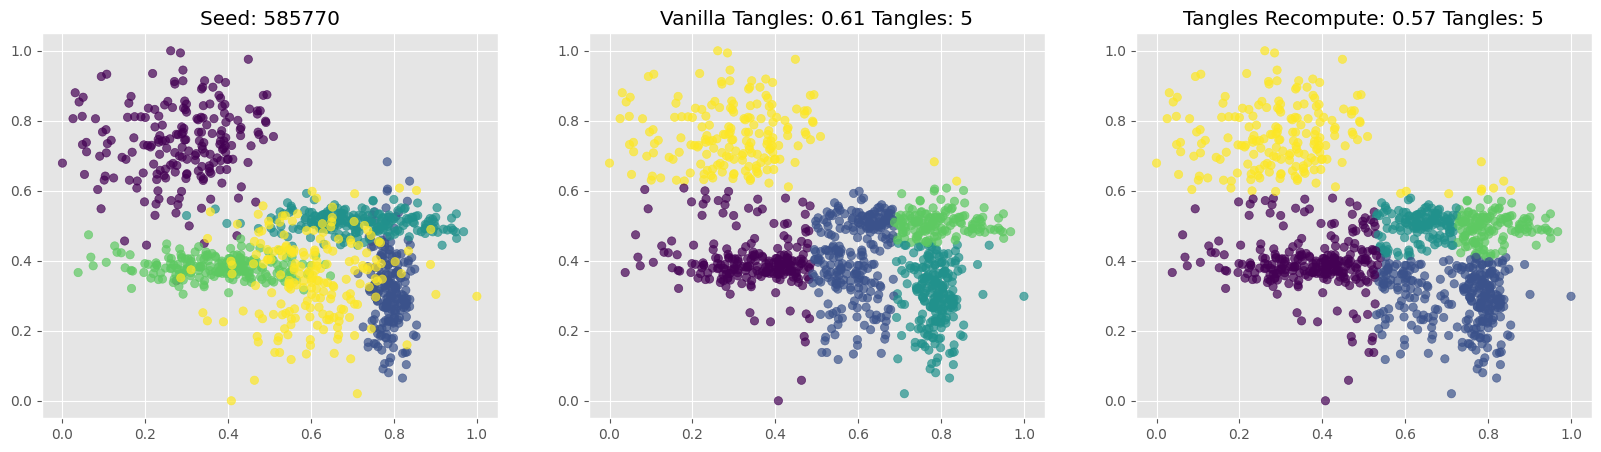

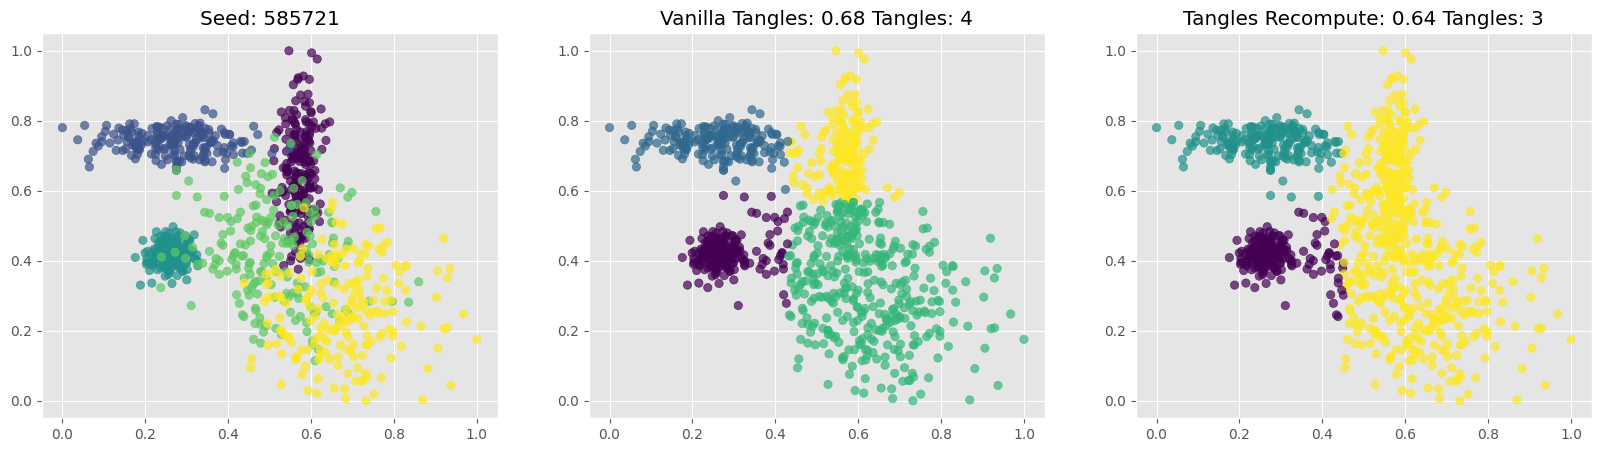

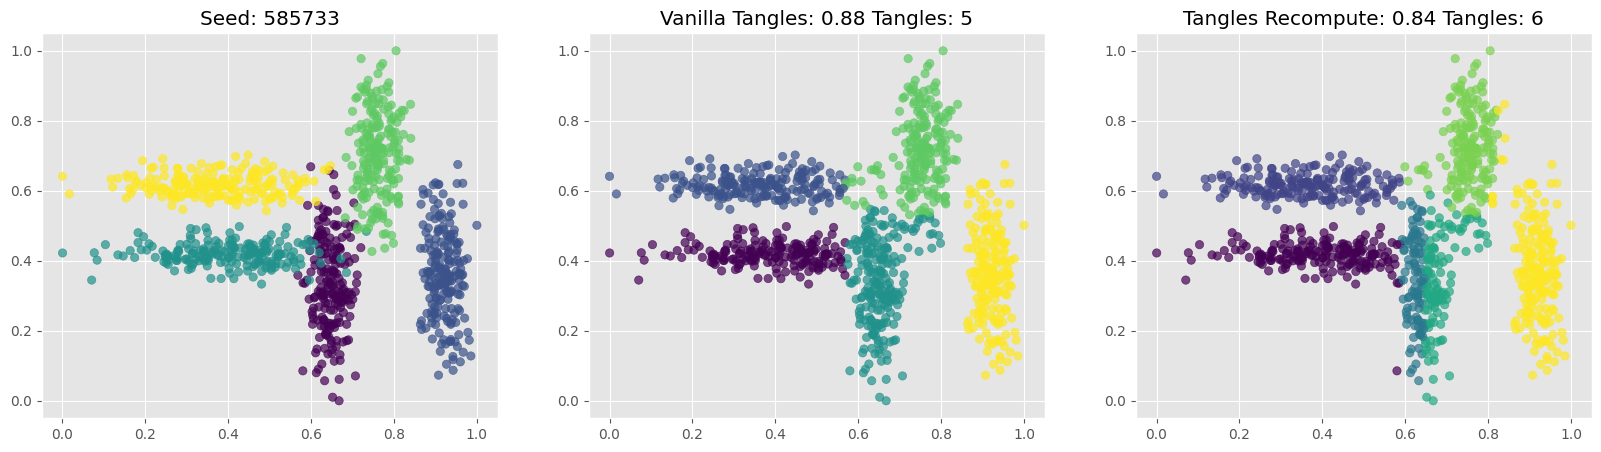

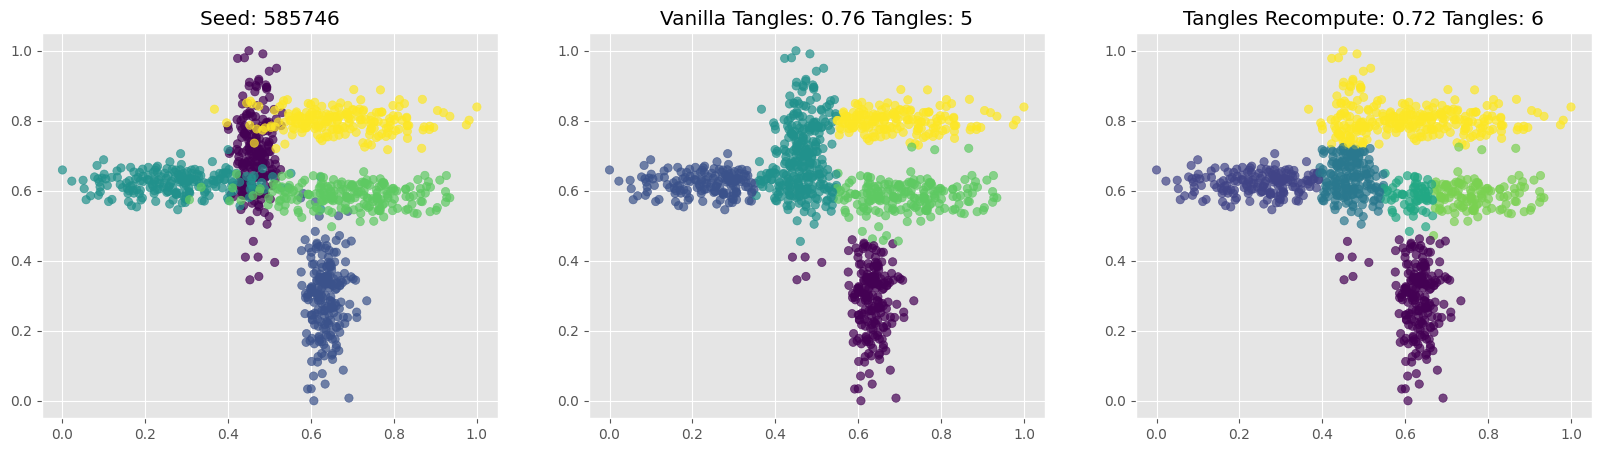

Clusters: 7
best
Clusters: 7
worst


In [15]:
reload()

NMI = sklearn.metrics.normalized_mutual_info_score

def plot_comparison(seed, n_clusters, data_size=1000):
    plt.style.use('ggplot')
    plt.figure(figsize=(20, 5))

    np.random.seed(seed)
    data, labels = dataset_generation.create_2d_test_data(
        means_func=means_func,
        n_clusters=n_clusters,
        dimensions=dimensions,
        scales=np.random.choice([0.5, 2], size=(n_clusters, dimensions)),
        weights=np.ones(n_clusters),
        min_distance=min_distance,
        num_samples=data_size
    )

    plt.subplot(1, 3, 1)
    plt.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.7)
    plt.title("Seed: " + str(seed))

    agreement_param = (min(Counter(labels).values()) * (0.35)) / len(labels)

    MinMaxScaler = sklearn.preprocessing.MinMaxScaler
    data = MinMaxScaler().fit_transform(data)

    models = {
                "Tangles": partial(tangles.TangleClustering,
                                            cost_class=cost_class,
                                            cut_function=cut_function,
                                            agreement_param=agreement_param
                                            ),
                "TanglesRecompute": partial(tangles.TangleClustering,
                                            cost_class=cost_class,
                                            cut_function=cut_function,
                                            agreement_param=agreement_param,
                                            recompute_costs_on_split=True,
                                            ),
            }

    model = models["Tangles"]()
    preds = model.fit_predict(data)

    # preds = tangles.TangleClustering(n_clusters=n_clusters, cost_class=cost_functions.SimilarityMatrix,
    #                                    cut_function=axis_parallel_cut_function,
    #                                    agreement_param=agreement_param).fit_predict(data)
    nmi = NMI(labels, preds)
    plt.subplot(1, 3, 2)
    plt.scatter(data[:, 0], data[:, 1], c=preds, alpha=0.7)
    plt.title(f"Vanilla Tangles: {nmi:.2f} Tangles: {len(np.unique(preds))}")

    model = models["TanglesRecompute"]()
    preds = model.fit_predict(data)
    # preds = tangles.TangleClustering(n_clusters=n_clusters, cost_class=cost_functions.SimilarityMatrix,
    #                                    cut_function=local_means_cut_function,
    #                                     # recompute_costs_on_split=True,
    #                                    agreement_param=agreement_param).fit_predict(data)
    nmi = NMI(labels, preds)
    plt.subplot(1, 3, 3)
    plt.scatter(data[:, 0], data[:, 1], c=preds, alpha=0.7)
    plt.title(f"Tangles Recompute: {nmi:.2f} Tangles: {len(np.unique(preds))}")


    plt.show()

for n_clusters in biggest_difference.keys():
    print(f"Clusters: {n_clusters}")
    print('best')
    for seed in biggest_difference[n_clusters]['best'][:5]:
        plot_comparison(seed, n_clusters)

    print(f"Clusters: {n_clusters}")
    print('worst')
    for seed in biggest_difference[n_clusters]['worst'][:5]:
        plot_comparison(seed, n_clusters)


     ____49_
    /       \
  _62       -69
 /   \
97    84


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   root
                                                                                                                                                                                                                                                                                                                  

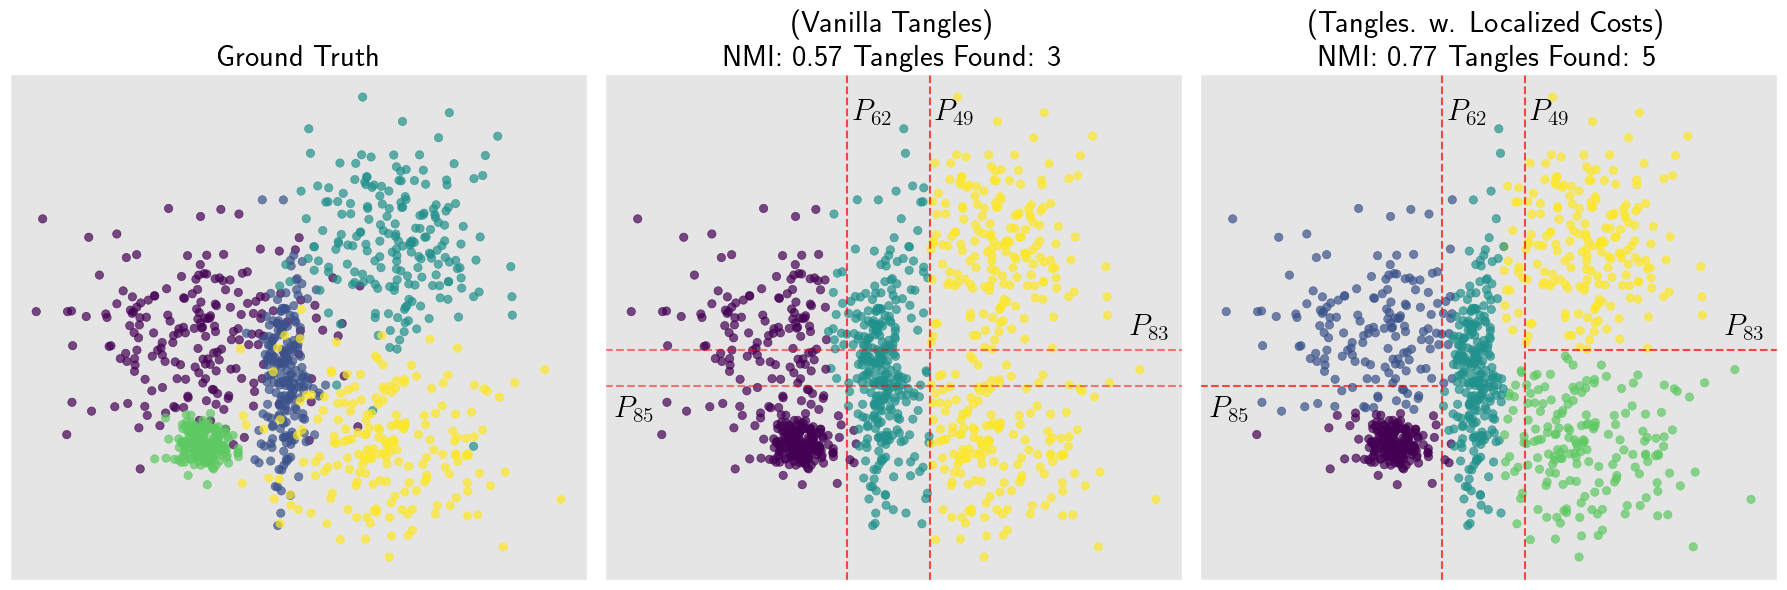

In [89]:
reload()
import matplotlib as mpl

mpl.rcParams["text.usetex"] = True
plt.style.use('ggplot')
plt.figure(figsize=(18, 6))

k = 50

data_size = 1000
n_clusters = 5
np.random.seed(585779)


data, labels = dataset_generation.create_2d_test_data(
        means_func=means_func,
        n_clusters=n_clusters,
        dimensions=dimensions,
        scales=np.random.choice([0.5, 2], size=(n_clusters, dimensions)),
        weights=np.ones(n_clusters),
        min_distance=min_distance,
        num_samples=data_size
)

plt.subplot(1, 3, 1)
plt.title("Ground Truth", fontsize=22)
plt.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.7)

plt.xticks([])
plt.yticks([])
cuts = np.zeros((data.shape[0], dimensions*k), dtype=np.int8)
i = 0

splits_x = np.linspace(data[:, 0].min(),
                        data[:, 0].max(), k+2)[1:-1]

splits = []

for split in splits_x:
    cuts[data[:, 0] < split, i] = 1
    i += 1
    splits.append(('x', split))

splits_y = np.linspace(data[:, 1].min(),
                        data[:, 1].max(), k+2)[1:-1]
for split in splits_y:
    cuts[data[:, 1] < split, i] = 1
    i += 1
    splits.append(('y', split))


data = sklearn.preprocessing.MinMaxScaler().fit_transform(data)
costs = cost_functions.SimilarityMatrix(data).compute_(cuts)
arg_sort = np.argsort(costs)
cuts = cuts[arg_sort]
splits = np.array(splits)[arg_sort]


agreement_param = (min(Counter(labels).values()) * (0.35)) / len(labels)

models = {
            "Tangles": partial(tangles.TangleClustering,
                                        cost_class=partial(cost_functions.SimilarityMatrix, margin=0.1),
                                        cut_function=partial(cut_finding.axis_parallel_cuts, k=k),
                                        agreement_param=agreement_param
                                        ),
            "TanglesRecompute": partial(tangles.TangleClustering,
                                        cost_class=partial(cost_functions.SimilarityMatrix, margin=0.1),
                                        cut_function=partial(cut_finding.axis_parallel_cuts, k=k),
                                        agreement_param=agreement_param,
                                        recompute_costs_on_split=True,
                                        ),
        }

model = models["Tangles"]()
preds = model.fit_predict(data)


# model.root.get_leaves(print_=True)

nmi = NMI(labels, preds)

plt.subplot(1, 3, 2)

plt.scatter(data[:, 0], data[:, 1], c=preds, alpha=0.7)
plt.title(f"(Vanilla Tangles)\nNMI: {nmi:.2f} Tangles Found: {len(np.unique(preds))}", fontsize=22)
plt.axvline(float(splits[49][1]), color='r', linestyle='--', alpha=0.7)

plt.axvline(float(splits[62][1]), color='r', linestyle='--', alpha=0.7)

plt.axhline(float(splits[83][1]), color='r', linestyle='--', alpha=0.5)

plt.axhline(float(splits[85][1]), color='r', linestyle='--', alpha=0.5)
plt.text(float(splits[49][1]) + 0.01, 0.95, r"$P_{49}$", fontsize=22, fontweight='bold')
plt.text(float(splits[62][1]) + 0.01, 0.95, r"$P_{62}$", fontsize=22, fontweight='bold')
plt.text(0.95, float(splits[83][1]) + 0.03, r"$P_{83}$", fontsize=22, fontweight='bold')
plt.text(-0.03, float(splits[85][1]) - 0.07, r"$P_{85}$", fontsize=22, fontweight='bold')

plt.xticks([])
plt.yticks([])
print(model.root)
model = models["TanglesRecompute"]()
preds = model.fit_predict(data)
# model.root.get_leaves(print_=True)

nmi = NMI(labels, preds)
plt.subplot(1, 3, 3)
plt.scatter(data[:, 0], data[:, 1], c=preds, alpha=0.7)


split_idx = [49, 62, 83, 85]

plt.axvline(float(splits[49][1]), color='r', linestyle='--', alpha=0.7)
plt.axvline(float(splits[62][1]), color='r', linestyle='--', alpha=0.7)

plt.axhline(float(splits[83][1]), xmin=float(splits[49][1]),
             color='r', linestyle='--', alpha=0.7)
plt.axhline(float(splits[85][1]),
            xmax=float(splits[62][1]), color='r', linestyle='--', alpha=0.7)
plt.text(float(splits[49][1]) + 0.01, 0.95, r"$P_{49}$", fontsize=22, fontweight='bold')
plt.text(float(splits[62][1]) + 0.01, 0.95, r"$P_{62}$", fontsize=22, fontweight='bold')
plt.text(0.95, float(splits[83][1]) + 0.03, r"$P_{83}$", fontsize=22, fontweight='bold')
plt.text(-0.03, float(splits[85][1]) - 0.07, r"$P_{85}$", fontsize=22, fontweight='bold')
plt.xticks([])
plt.yticks([])

plt.title(f"(Tangles. w. Localized Costs)\nNMI: {nmi:.2f} Tangles Found: {len(np.unique(preds))}", fontsize=22)

plt.tight_layout()
plt.savefig("plots/recompute_complex.png", dpi=300, bbox_inches='tight')
plt.show()

